In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [3]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [4]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1) # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [5]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [6]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]           just the stock return formula 

df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

Note = we use the first 10 values to train with the 11th value, so the first object being nan does not cause any effect

In [7]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


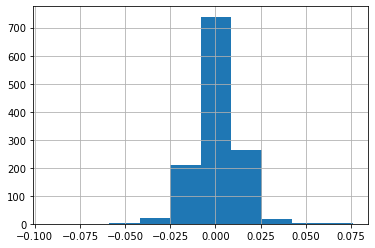

In [8]:
# Now let's try an LSTM to predict returns
df['Return'].hist()

In [9]:
# we see most values are really small. so we need to scale them

series = df['Return'].values[1:].reshape(-1,1)     #ignoring the first value

In [10]:
sc = StandardScaler ()

## Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.

In [11]:
sc.fit(series[:len(series//2)])      # done only on first half, as we dont want to include test data on training pipeline

StandardScaler(copy=True, with_mean=True, with_std=True)

In [12]:
series = sc.transform(series).flatten()

In [13]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
    X.append(series[t:t+T])
    Y.append(series[t+T])
    
X = np.array(X).reshape(-1, T, D) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1248, 10, 1) Y.shape (1248,)


In [14]:
#rnn

i = Input(shape=(T,1))
x = LSTM(50, return_sequences=True)(i)
x = Dropout(0.2)(x)
x = LSTM(50, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = LSTM(50, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = LSTM(50)(x)
x = Dropout(0.2)(x)
x = Dense(1)(x)

model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01))

In [15]:
r = model.fit(X[:-N//2], Y[:-N//2], validation_data = (X[-N//2:], Y[-N//2:]), epochs = 100 )

Train on 624 samples, validate on 624 samples
Epoch 1/100
624/624 [==============================] - 7s 11ms/sample - loss: 0.9576 - val_loss: 1.0739
Epoch 2/100
624/624 [==============================] - 0s 768us/sample - loss: 0.9478 - val_loss: 1.0659
Epoch 3/100
624/624 [==============================] - 0s 770us/sample - loss: 0.9337 - val_loss: 1.0800
Epoch 4/100
624/624 [==============================] - 0s 772us/sample - loss: 0.9369 - val_loss: 1.0782
Epoch 5/100
624/624 [==============================] - 0s 764us/sample - loss: 0.9343 - val_loss: 1.0756
Epoch 6/100
624/624 [==============================] - 0s 768us/sample - loss: 0.9363 - val_loss: 1.0710
Epoch 7/100
624/624 [==============================] - 0s 759us/sample - loss: 0.9293 - val_loss: 1.0917
Epoch 8/100
624/624 [==============================] - 0s 759us/sample - loss: 0.9204 - val_loss: 1.0726
Epoch 9/100
624/624 [==============================] - 0s 757us/sample - loss: 0.9290 - val_loss: 1.0718
Epoch 10/1

624/624 [==============================] - 0s 764us/sample - loss: 0.5842 - val_loss: 1.3800
Epoch 78/100
624/624 [==============================] - 0s 767us/sample - loss: 0.5426 - val_loss: 1.3802
Epoch 79/100
624/624 [==============================] - 0s 770us/sample - loss: 0.4839 - val_loss: 1.3809
Epoch 80/100
624/624 [==============================] - 0s 775us/sample - loss: 0.4833 - val_loss: 1.3888
Epoch 81/100
624/624 [==============================] - 0s 767us/sample - loss: 0.4984 - val_loss: 1.4602
Epoch 82/100
624/624 [==============================] - 0s 768us/sample - loss: 0.4897 - val_loss: 1.4707
Epoch 83/100
624/624 [==============================] - 0s 762us/sample - loss: 0.5267 - val_loss: 1.3577
Epoch 84/100
624/624 [==============================] - 0s 767us/sample - loss: 0.4950 - val_loss: 1.3961
Epoch 85/100
624/624 [==============================] - 0s 767us/sample - loss: 0.4930 - val_loss: 1.2980
Epoch 86/100
624/624 [==============================] - 0s 

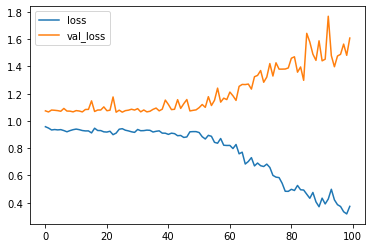

In [16]:
# Plot loss per iteration

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1248, 1)


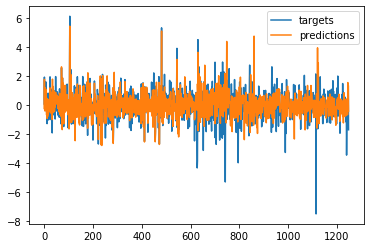

In [17]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

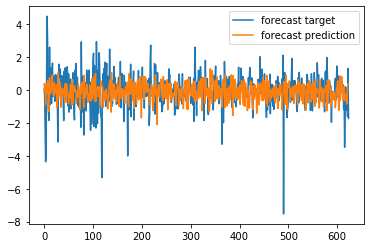

In [18]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()